<a href="https://colab.research.google.com/github/JuhiNayak/Machine-Learning/blob/master/GMM_Loan_JuhiNayak.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CMPE 257: Assignment Week 2

Author: Juhi Nayak

Applying gmm algorithm using Scikit-learn

Dataset Source: https://www.kaggle.com/altruistdelhite04/loan-prediction-problem-dataset?select=train_u6lujuX_CVtuZ9i.csv

Reference: https://colab.research.google.com/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.12-Gaussian-Mixtures.ipynb#scrollTo=3t8CM1BKLtUg

Importing Libraries

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Upload file form local drive

In [ ]:
from google.colab import files 
uploaded = files.upload()

Saving datasets_bank_laon.csv to datasets_bank_laon.csv


Read csv file and store in dataframe

In [ ]:
import io
import pandas as pd
df = pd.read_csv(io.BytesIO(uploaded['datasets_bank_laon.csv']), encoding='latin-1')
df.head(5)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


Data preparation: Handle Null values

In [ ]:
df.fillna(df.mean(), inplace=True)
df.isna().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount            0
Loan_Amount_Term      0
Credit_History        0
Property_Area         0
Loan_Status           0
dtype: int64

Calculate the total income and store in a new column in dataframe

In [ ]:
totalIncome = df["ApplicantIncome"] + df["CoapplicantIncome"]
df["totalIncome"] = totalIncome
df.head(5)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,totalIncome
0,LP001002,Male,No,0,Graduate,No,5849,0.0,146.412162,360.0,1.0,Urban,Y,5849.0
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.000000,360.0,1.0,Rural,N,6091.0
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.000000,360.0,1.0,Urban,Y,3000.0
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.000000,360.0,1.0,Urban,Y,4941.0
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.000000,360.0,1.0,Urban,Y,6000.0


Allocating the Total income and loan amount from dataframe into an array

In [ ]:
X = df.iloc[:,[13,8]].values
print(X)

[[5849.          146.41216216]
 [6091.          128.        ]
 [3000.           66.        ]
 ...
 [8312.          253.        ]
 [7583.          187.        ]
 [4583.          133.        ]]


Data Standardization

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler() 
data_scaled = scaler.fit_transform(X)

Data visualization in the plot for kmeans clustering

In [ ]:

from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

def plot_kmeans(kmeans, X, n_clusters=3, rseed=0, ax=None):
    plt.figure(figsize = (10,8))
    labels = kmeans.fit_predict(X)

    # plot the input data
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)

    # plot the representation of the KMeans model
    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max()
             for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))

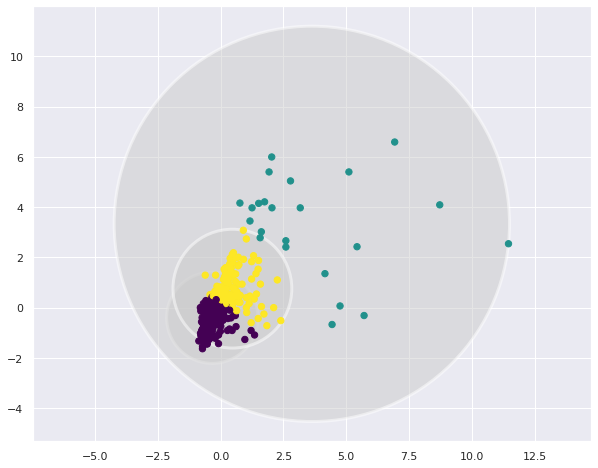

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=0)
plot_kmeans(kmeans, data_scaled)

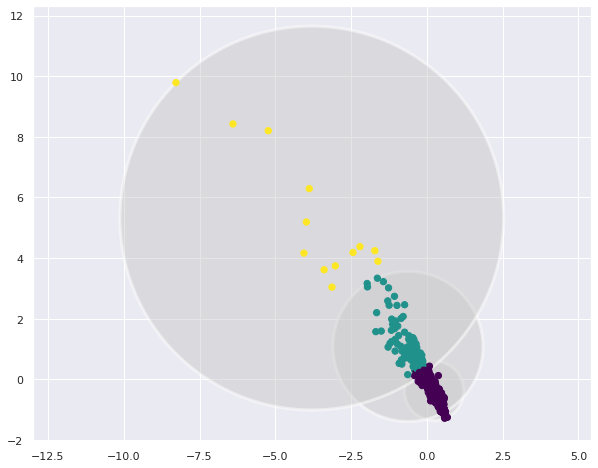

In [ ]:
rng = np.random.RandomState(13)
X_stretched = np.dot(data_scaled, rng.randn(2, 2))

kmeans = KMeans(n_clusters=3, random_state=0)
plot_kmeans(kmeans, X_stretched)

Applying gmm algorithm on the scaled data taken from the dataframe for clusters = 3

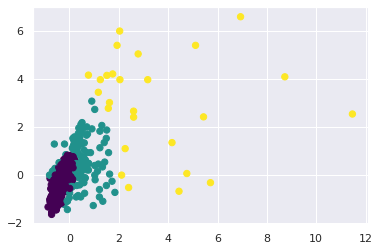

In [ ]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=3).fit(data_scaled)
labels = gmm.predict(data_scaled)
plt.scatter(data_scaled[:, 0], data_scaled[:, 1], c=labels, s=40, cmap='viridis');

find probabilistic cluster assignments

In [ ]:
probs = gmm.predict_proba(data_scaled)
print(probs[:5].round(3))

[[0.97  0.03  0.   ]
 [0.965 0.035 0.   ]
 [0.989 0.011 0.   ]
 [0.985 0.015 0.   ]
 [0.969 0.031 0.   ]]


Visualizing uncertainity of the cluster assignment

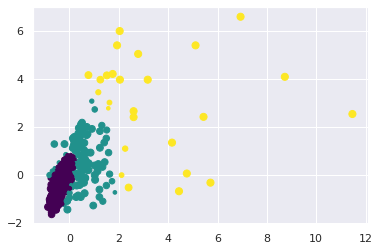

In [ ]:
size = 50 * probs.max(1) ** 2  # square emphasizes differences
plt.scatter(data_scaled[:, 0], data_scaled[:, 1], c=labels, cmap='viridis', s=size);

Function to visualize the locations and shapes of the GMM clusters by drawing ellipses based on the GMM output:

In [ ]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    plt.figure(figsize = (10,8))
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

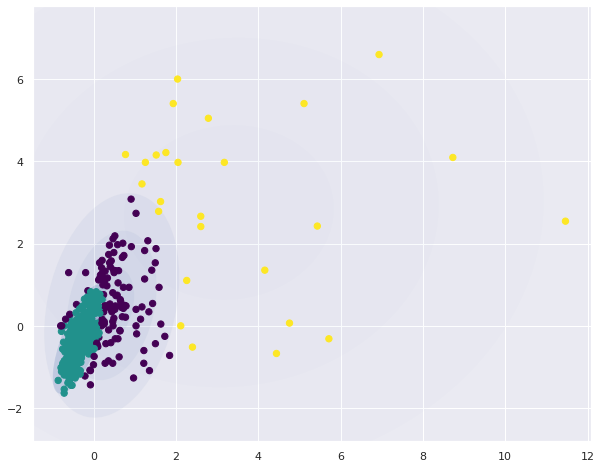

In [ ]:
gmm = GaussianMixture(n_components=3, random_state=42)
plot_gmm(gmm, data_scaled)

GMM to fit our stretched dataset; allowing for a diag covariance the model will fit even very oblong, stretched-out clusters:

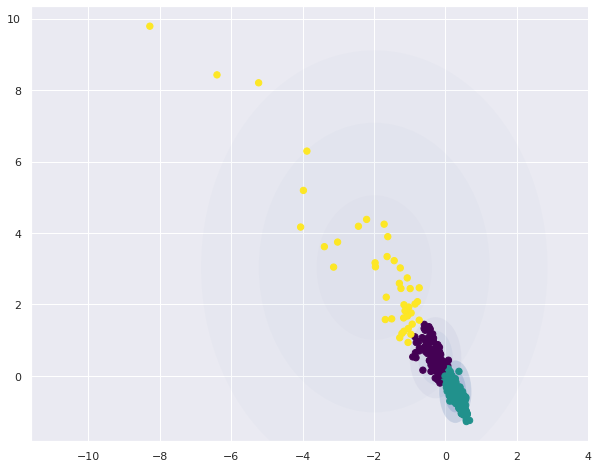

In [ ]:
gmm = GaussianMixture(n_components=3, covariance_type='diag', random_state=42)
plot_gmm(gmm, X_stretched)

Using the AIC and BIC function to get the optimal number of components to form a cluster

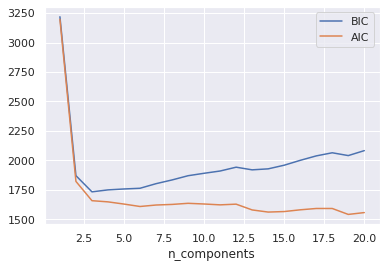

In [ ]:
n_components = np.arange(1, 21)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(data_scaled)
          for n in n_components]

plt.plot(n_components, [m.bic(data_scaled) for m in models], label='BIC')
plt.plot(n_components, [m.aic(data_scaled) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

Clustering with 6 compnents

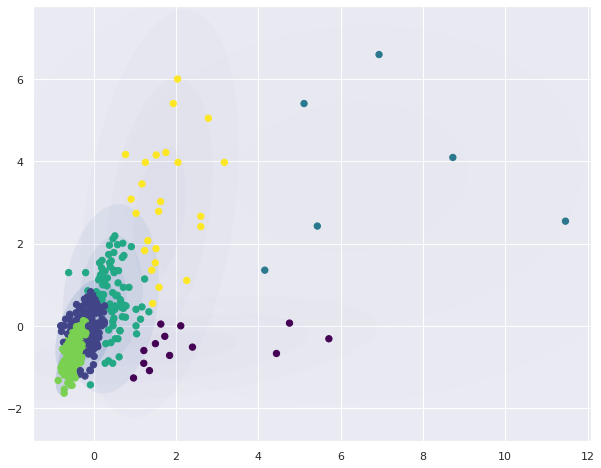

In [ ]:
gmm = GaussianMixture(n_components=6, random_state=42)
plot_gmm(gmm, data_scaled)

When comparing K-Means Algorithm with Gaussian Mixture Model Algorithm, I observed Gmm has better mechanism to perform clustering.

K-Means uses Hard Assignment, where it sets the centroid and apply clustering on the data points near the centroid based on the mean. Whereas, Gmm uses Soft Assignment where it uses probability to assign the data point to a cluster.

K-Means uses Elbow method to get the optimized number of clusters which might not be as optimal as we can get in Gmm using AIC and BIC functions.

Gmm provides better clustering as it can work with any type of data and does not consider the geographical shape of the data. Whereas K-Means assumes the data as spherical/circular which might limit the scope of clustering.
